---
{}

---



In [ ]:
#| default_exp chem

# Chemistry
https://quantum.cloud.ibm.com/docs/en/tutorials/sample-based-quantum-diagonalization#quantum-chemistry

The properties of molecules are largely determined by the structure of the electrons within them. As **fermionic particles**, electrons can be described using a mathematical formalism called **second quantization**.  

The idea is that there are a number of **orbitals**, each of which can be either empty or occupied by a fermion.  

A system of \( N \) orbitals is described by a set of **fermionic annihilation operators**:

$$
\{ \hat{a}^p \}_{p=1}^N
$$

that satisfy the **fermionic anticommutation relations**:

$$
\hat{a}^p \hat{a}^q + \hat{a}^q \hat{a}^p = 0,
$$
$$
\hat{a}^p \hat{a}^{q\dagger} + \hat{a}^{q\dagger} \hat{a}^p = \delta_{pq}.
$$

The adjoint $ \hat{a}^{p\dagger} $ is called a **creation operator**.

---

## Spin Considerations

So far, our exposition has not accounted for **spin**, which is a fundamental property of fermions.  

When accounting for spin, the orbitals come in pairs called **spatial orbitals**. Each spatial orbital is composed of two **spin orbitals**:

- One labeled **spin-α**
- One labeled **spin-β**

We then write $ \hat{a}^{p\sigma} $ for the annihilation operator associated with the spin-orbital with spin $ \sigma $ $ \sigma \in \{\alpha, \beta\} $ in spatial orbital $ p $.

If we take \( N \) to be the number of spatial orbitals, then there are a total of $ 2N $ spin-orbitals.

The **Hilbert space** of this system is spanned by $ 2^{2N} $ orthonormal basis vectors labeled with two-part bitstrings:

$$
| z \rangle = | z_\beta z_\alpha \rangle
= | z_{\beta, N} \cdots z_{\beta, 1} \; z_{\alpha, N} \cdots z_{\alpha, 1} \rangle
$$

---

## Molecular Hamiltonian

The Hamiltonian of a molecular system can be written as:

$$
\hat{H} =
\sum_{pr\sigma} h_{pr} \, \hat{a}^{p\sigma\dagger} \hat{a}^{r\sigma}
+ \frac{1}{2} \sum_{prqs\sigma\tau} h_{prqs} \, \hat{a}^{p\sigma\dagger} \hat{a}^{q\tau\dagger} \hat{a}^{s\tau} \hat{a}^{r\sigma}
$$

where:

- $ h_{pr} $ and $ h_{prqs} $ are complex numbers called **molecular integrals**.
- These integrals can be calculated from the specification of the molecule using a computer program.

In this tutorial, we compute the integrals using the **[PySCF](https://pyscf.org/)** software package.

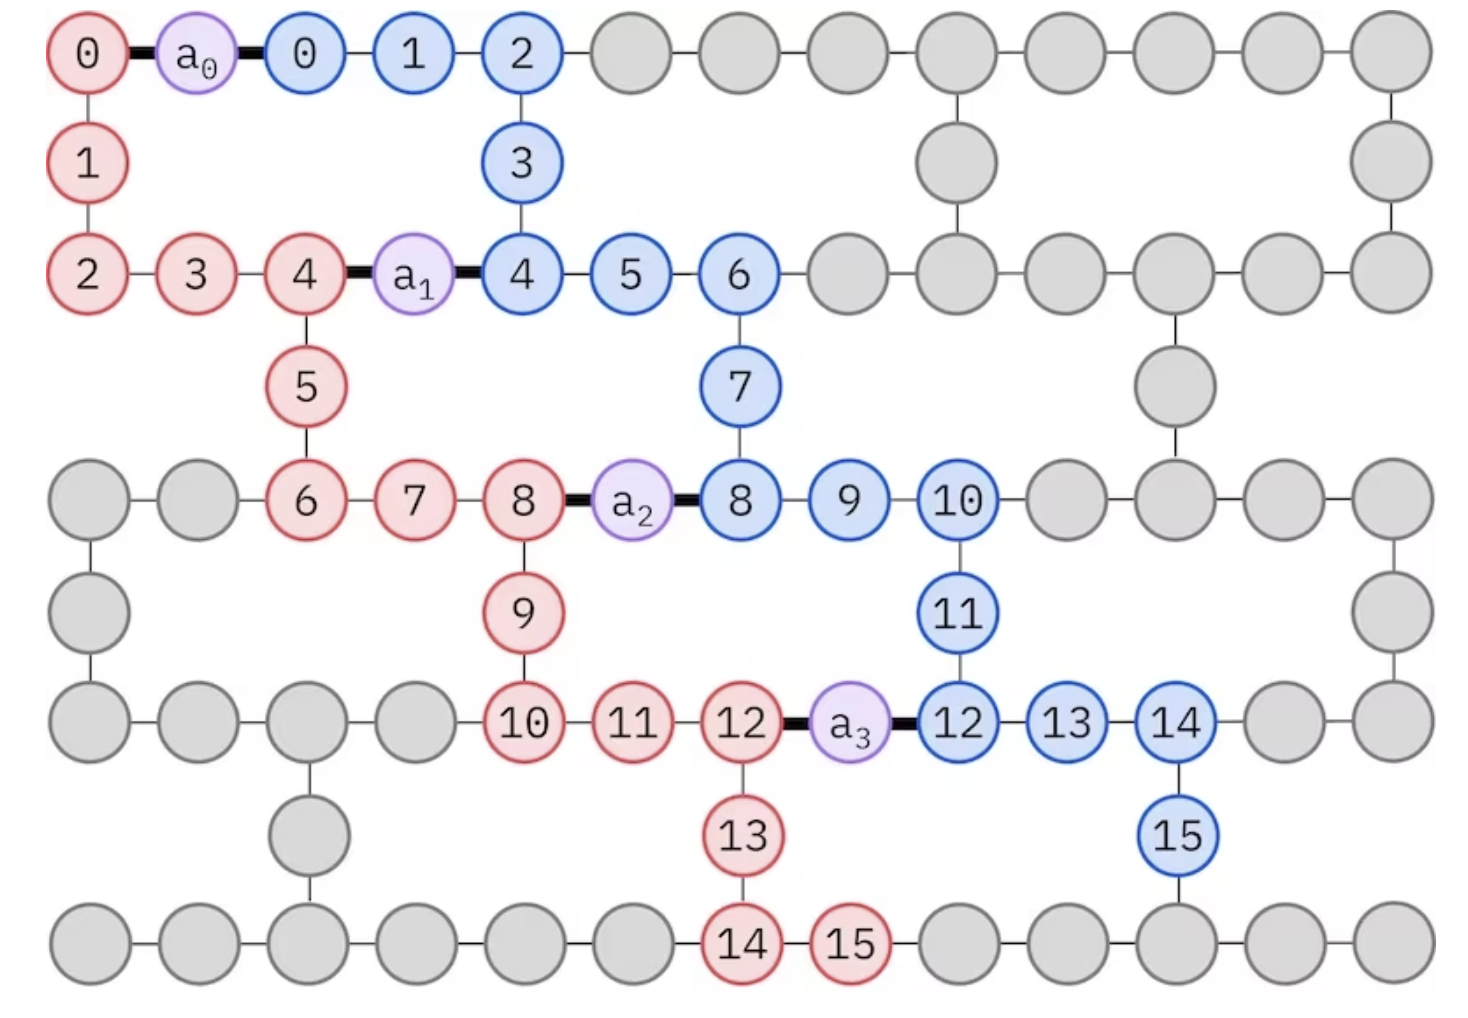

In [ ]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt
 
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [ ]:
# Specify molecule properties
open_shell = False
spin_sq = 0
 
# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="cc-pvdz",
    symmetry="Dooh",
)
 
# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())
 
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)
 
# Store reference energy from SCI calculation performed separately
exact_energy = -109.22690201485733

converged SCF energy = -108.929838385609


In [ ]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.2177884185544  E_corr = -0.2879500329450041


In [ ]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]
 
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)
 
nelec = (num_elec_a, num_elec_b)
 
# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)
 
# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
 
# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

In [ ]:
circuit.decompose(reps=3).draw()

In [ ]:
#TODO support more customized gates such like sdg, s, square root x

: 

: 

: 